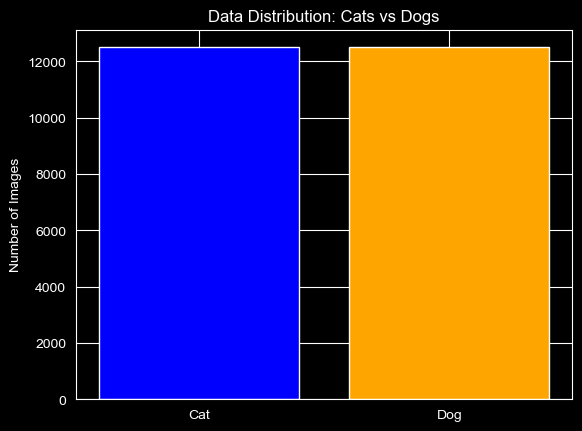

Stats: {'Cat': 12500, 'Dog': 12500}


In [19]:
import os
import matplotlib.pyplot as plt
from PIL import Image


data_dir = 'PetImages'
categories = ['Cat', 'Dog']

def perform_eda(data_path):
    counts = {}
    for category in categories:
        path = os.path.join(data_path, category)

        counts[category] = len([f for f in os.listdir(path) if f.endswith(('.jpg', '.png'))])


    plt.bar(counts.keys(), counts.values(), color=['blue', 'orange'])
    plt.title('Data Distribution: Cats vs Dogs')
    plt.ylabel('Number of Images')
    plt.show()
    return counts


stats = perform_eda(data_dir)
print(f"Stats: {stats}")

In [20]:
import numpy as np

def preprocess_images(data_path, img_size=(64, 64)):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_path, category)
        label = categories.index(category) # Encoding: Cat=0, Dog=1

        for img_name in os.listdir(path)[:500]:
            try:
                img_path = os.path.join(path, img_name)

                img = Image.open(img_path).convert('L').resize(img_size)
                data.append(np.array(img).flatten())
                labels.append(label)
            except:

                continue

    return np.array(data), np.array(labels)

X, y = preprocess_images(data_dir)
print(f"Data shape after preprocessing: {X.shape}")

Data shape after preprocessing: (1000, 4096)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear')
}


results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}")


best_model_name = max(results, key=results.get)
print(f"\nالنموذج الأفضل الذي سنختاره هو: {best_model_name}")

Logistic Regression Accuracy: 0.51
SVM Accuracy: 0.51

النموذج الأفضل الذي سنختاره هو: SVM


In [39]:
from PIL import ImageFile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True
# 1. تحديد المسار (تأكد أن المجلد في نفس مكان ملف الكود)
base_dir = 'PetImages'

# 2. المعالجة المسبقة (Scaling & Augmentation)
# نستخدم ImageDataGenerator لتوحيد المقياس وتجنب النتائج الكارثية
train_datagen = ImageDataGenerator(
    rescale=1./255,    # Scaling: تحويل قيم البكسل من 0-255 إلى 0-1
    validation_split=0.2 # تقسيم البيانات (Train/Validation)
)

# تحميل البيانات من المجلدات مباشرة
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(64, 64), # توحيد المقاس
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# 3. بناء النموذج (المتوافق مع التحذير السابق)
model = models.Sequential([
    Input(shape=(64, 64, 3)), # 3 للألوان RGB
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Found 18739 images belonging to 2 classes.
Found 4683 images belonging to 2 classes.
Epoch 1/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.5972 - loss: 0.6532 - val_accuracy: 0.7457 - val_loss: 0.5102
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.7597 - loss: 0.4959 - val_accuracy: 0.7600 - val_loss: 0.4957
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - accuracy: 0.7996 - loss: 0.4341 - val_accuracy: 0.7882 - val_loss: 0.4390
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - accuracy: 0.8303 - loss: 0.3756 - val_accuracy: 0.7999 - val_loss: 0.4202
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.8547 - loss: 0.3250 - val_accuracy: 0.7976 - val_loss: 0.4623


In [36]:
import os
import tensorflow as tf
from PIL import Image, ImageFile

# 1. السماح بقراءة الصور الناقصة (حل مشكلة Truncated File)
ImageFile.LOAD_TRUNCATED_IMAGES = True


def clean_bad_images(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                try:
                    with open(path, "rb") as f:

                        is_jfif = tf.compat.as_bytes("JFIF") in f.peek(10)
                    if not is_jfif:
                        # حذف الصور التي لا تتبع تنسيق JFIF القياسي (تسبب مشاكل لـ TF)
                        os.remove(path)
                except:
                    os.remove(path)

clean_bad_images('PetImages')

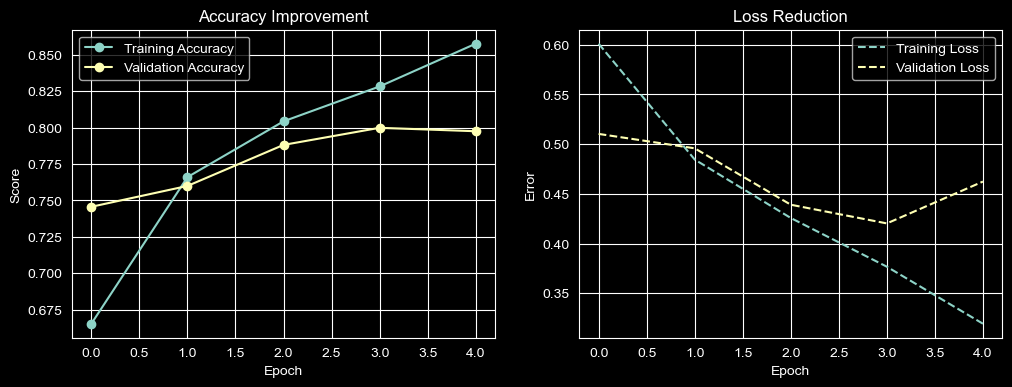

In [40]:
import matplotlib.pyplot as plt

# رسم منحنى الدقة (Accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Improvement')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# رسم منحنى الخسارة (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Reduction')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
النموذج يتوقع أن هذه الصورة: كلب 🐶 بنسبة ثقة 82.44%


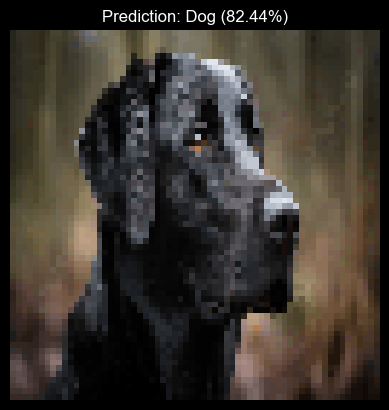

In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


img_path = r'C:\Users\haama\Desktop\photo\2.jpg'


try:

    img = image.load_img(img_path, target_size=(64, 64))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0) # إضافة بعد الـ Batch


    prediction = model.predict(img_array)


    plt.imshow(img)
    if prediction[0] > 0.5:
        result = f"Dog ({prediction[0][0]*100:.2f}%)"
        plt.title(f"Prediction: {result}")
        print(f"النموذج يتوقع أن هذه الصورة: كلب 🐶 بنسبة ثقة {prediction[0][0]*100:.2f}%")
    else:
        result = f"Cat ({(1-prediction[0][0])*100:.2f}%)"
        plt.title(f"Prediction: {result}")
        print(f"النموذج يتوقع أن هذه الصورة: قطة 🐱 بنسبة ثقة {(1-prediction[0][0])*100:.2f}%")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"حدث خطأ أثناء تحميل الصورة: {e}")

In [58]:
# 1. حفظ النموذج بالكامل (البنية + الأوزان + الإعدادات)
model.save('best_cnn_model.keras')

print("✅ تم حفظ النموذج بنجاح في ملف واحد بصيغة .keras")

✅ تم حفظ النموذج بنجاح في ملف واحد بصيغة .keras


In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

def load_and_preprocess_images(data_path, img_size=(64, 64)):
    images = []
    labels = []
    for category in ['cat', 'dog']:
        path = os.path.join(data_path, category)
        label = 0 if category == 'cat' else 1
        for img_name in os.listdir(path):
            try:
                # 1. Scaling: توحيد المقاس وتقليل الأبعاد لتسريع المعالجة
                img = Image.open(os.path.join(path, img_name)).convert('L') # Convert to Grayscale
                img = img.resize(img_size)
                # 2. Flattening: تحويل الصورة لمصفوفة أحادية
                images.append(np.array(img).flatten())
                labels.append(label)
            except Exception as e:
                pass
    return np.array(images), np.array(labels)

# ملاحظة: الخطوات أعلاه تتبع مبدأ المعالجة المسبقة (Preprocessing) المذكور في [cite: 10, 11]